
## Transformer model

* So let's start by importing all required libraries

In [1]:
import tensorflow as tf
import re
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from nltk import ngrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import random

2025-12-10 04:51:05.736857: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 04:51:05.794918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 04:51:08.636803: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Setting random seed for reproducability
tf.random.set_seed(1234)
# Setting autotune which automatically let's tensorflow to tune data pipeline performance
AUTO = tf.data.experimental.AUTOTUNE
# Printing tensorflow version
print("Tensorflow version {}".format(tf.__version__))

Tensorflow version 2.20.0


### Transformer Hyperparameters

* To keep this example small and relatively fast, we reduce values for *num_layers, d_model, and units*.

In [3]:
# Maximum sentence length
MAX_LENGTH = 20
# Maximum number of samples to preprocess
MAX_SAMPLES = 50000
# For tf.data.Dataset
BATCH_SIZE = 64
BUFFER_SIZE = 20000
# For Transformer
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1
EPOCHS = 100

### Shakespeare sonnets preprocessing

* Let's write a function for cleaning numbers and hyphen

In [4]:
def clean_numbers(text):
    """Function for cleaning numbers"""
    pattern = r"[\d-]"
    return re.sub(pattern, '', text)

* Now let's load the data

In [5]:
text = ''
print( "Reading txt file...")
with open('./data/shakespeare-sonnets.txt', 'r') as f:
    text = f.read()

Reading txt file...


* Now let's replace punctuations with special tokens

In [6]:
text = text.replace(",\n", " _eol_ ")
text = text.replace(",", " _comma_  ")
text = text.replace(":", " _comma_  ")
text = text.replace(";", " _comma_  ")

* Now let's replace ending of lines with some punctuations with full stop
* Remove comma and tabs and extra spaces
* Use written clean numbers to remove numbers
* Expand contractions
* Convert all text to lowercase

In [7]:
# Replace line endings with full stop
text = text.replace("?\n", ". ")
text = text.replace("!\n", ". ")
text = text.replace(".\n", ". ")
text = text.replace("?", ".")
text = text.replace("!", ".")
# Remove comma
text = text.replace('"',"")
# Remove tabs
text = text.replace("\t", "")
# Remove extra spaces
text = text.replace("  ", "")
# Remove numbers
text = clean_numbers(text)
# Remove soace
_RE_COMBINE_WHITESPACE = re.compile(r"\s+")
text = _RE_COMBINE_WHITESPACE.sub(" ", text).strip()
# Expanding contractions
text = re.sub(r"i'm", "i am", text)
text = re.sub(r"he's", "he is", text)
text = re.sub(r"she's", "she is", text)
text = re.sub(r"it's", "it is", text)
text = re.sub(r"that's", "that is", text)
text = re.sub(r"what's", "that is", text)
text = re.sub(r"where's", "where is", text)
text = re.sub(r"how's", "how is", text)
text = re.sub(r"\'ll", " will", text)
text = re.sub(r"\'ve", " have", text)
text = re.sub(r"\'re", " are", text)
text = re.sub(r"\'d", " would", text)
text = re.sub(r"\'re", " are", text)
text = re.sub(r"won't", "will not", text)
text = re.sub(r"can't", "cannot", text)
text = re.sub(r"n't", " not", text)
text = re.sub(r"n'", "ng", text)
text = re.sub(r"'bout", "about", text)
# Converting all text to lowercase
text = text.lower()
# Replacing lowercase i to uppercase I
text = text.replace('i ', 'I ')

* Let's now check the length of text and few lines of it

In [8]:
len(text)

106278

In [9]:
text[0:2000]

"from fairest creatures we desire increase _eol_ that thereby beauty's rose might never die _eol_ but _comma_ as the riper should by time decease _eol_ his tender heir might bear his memory. but thou _comma_ contracted to thine own bright eyes _eol_ feed'st thy light's flame with selfsubstantial fuel _eol_ making a famine where abundance lies _eol_ thyself thy foe _comma_ to thy sweet self too cruel. thou that art now the world's fresh ornament and only herald to the gaudy spring within thine own bud buriest thy content and _comma_ tender churl _comma_ mak'st waste in niggarding. pity the world _comma_ or else this glutton be to eat the world's due _comma_ by the grave and thee. when forty winters shall besiege thy brow and dig deep trenches in thy beauty's field _eol_ thy youth's proud livery _comma_ so gazed on now _eol_ will be a tattered weed of small worth held. then being asked where all thy beauty lies _eol_ where all the treasure of thy lusty days _eol_ to say within thine own 

* Let's harvest all ngrams up to 20:

In [10]:
ngrams_up_to_20 = []
for i in tqdm(range(2, 21)):
    ngram_counts = Counter(ngrams(text.split(), i))
    print('ngram-', i, 'length:', len(ngram_counts))
    ngrams_up_to_20.append(ngram_counts)

  0%|          | 0/19 [00:00<?, ?it/s]

ngram- 2 length: 13985
ngram- 3 length: 18762
ngram- 4 length: 19415
ngram- 5 length: 19497
ngram- 6 length: 19522
ngram- 7 length: 19537
ngram- 8 length: 19550
ngram- 9 length: 19561
ngram- 10 length: 19571
ngram- 11 length: 19581
ngram- 12 length: 19588
ngram- 13 length: 19595
ngram- 14 length: 19602
ngram- 15 length: 19608
ngram- 16 length: 19613


100%|██████████| 19/19 [00:00<00:00, 130.36it/s]

ngram- 17 length: 19616
ngram- 18 length: 19618
ngram- 19 length: 19620
ngram- 20 length: 19621


* As you canm see that we have generated ngrams up to 20 so now let's view most common n grams
* Let's view most common bigrams

In [11]:
ngrams_up_to_20[0].most_common(10)

[(('_eol_', 'and'), 150),
 (('_comma_', 'and'), 107),
 (('o', '_comma_'), 44),
 (('_comma_', 'but'), 39),
 (('love', '_comma_'), 37),
 (('my', 'love'), 37),
 (('_eol_', 'that'), 36),
 (('thou', 'art'), 31),
 (('in', 'the'), 31),
 (('_comma_', 'I'), 30)]

* Now let's view most common trigrams

In [12]:
ngrams_up_to_20[1].most_common(10)

[(('_comma_', 'love', '_comma_'), 8),
 (('my', 'love', '_comma_'), 7),
 (('_eol_', 'and', 'in'), 7),
 (('_eol_', 'and', 'all'), 6),
 (('_comma_', 'and', 'I'), 6),
 (('some', 'in', 'their'), 6),
 (('_comma_', 'when', 'I'), 5),
 (('_comma_', 'and', '_comma_'), 5),
 (('_eol_', 'and', 'you'), 5),
 (('thy', 'love', '_comma_'), 5)]

* Now let's view most common 3-grams

In [13]:
ngrams_up_to_20[2].most_common(10)

[(('_comma_', 'why', 'dost', 'thou'), 3),
 (('when', 'I', 'have', 'seen'), 3),
 (('_comma_', 'some', 'in', 'their'), 3),
 (('_eol_', 'some', 'in', 'their'), 3),
 (('fair', '_comma_', 'kind', '_comma_'), 3),
 (('_comma_', 'kind', '_comma_', 'and'), 3),
 (('kind', '_comma_', 'and', 'true'), 3),
 (('_comma_', 'that', 'I', 'have'), 3),
 (('for', 'I', 'have', 'sworn'), 3),
 (('the', 'treasure', 'of', 'thy'), 2)]

### Tokenization of words into integers

* Let's now split sentences and view first four sentences

In [14]:
training_data = text.split('.')
training_data[0:4]

["from fairest creatures we desire increase _eol_ that thereby beauty's rose might never die _eol_ but _comma_ as the riper should by time decease _eol_ his tender heir might bear his memory",
 " but thou _comma_ contracted to thine own bright eyes _eol_ feed'st thy light's flame with selfsubstantial fuel _eol_ making a famine where abundance lies _eol_ thyself thy foe _comma_ to thy sweet self too cruel",
 " thou that art now the world's fresh ornament and only herald to the gaudy spring within thine own bud buriest thy content and _comma_ tender churl _comma_ mak'st waste in niggarding",
 " pity the world _comma_ or else this glutton be to eat the world's due _comma_ by the grave and thee"]

* Now let's remove spaces at start and end from sentences

In [15]:
for i in range(len(training_data)):
    training_data[i] = training_data[i].strip()
training_data[0:4]

["from fairest creatures we desire increase _eol_ that thereby beauty's rose might never die _eol_ but _comma_ as the riper should by time decease _eol_ his tender heir might bear his memory",
 "but thou _comma_ contracted to thine own bright eyes _eol_ feed'st thy light's flame with selfsubstantial fuel _eol_ making a famine where abundance lies _eol_ thyself thy foe _comma_ to thy sweet self too cruel",
 "thou that art now the world's fresh ornament and only herald to the gaudy spring within thine own bud buriest thy content and _comma_ tender churl _comma_ mak'st waste in niggarding",
 "pity the world _comma_ or else this glutton be to eat the world's due _comma_ by the grave and thee"]

### Building Tokenizer

In [16]:
tokenizer = Tokenizer()
# Fit the tokenizer on the training data
tokenizer.fit_on_texts(training_data)
# Convert the training data into sequences of tokens
sequences = tokenizer.texts_to_sequences(training_data)
# Pad the sequences to have the same length
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH)

* Now let's see length of tokenizer word counts

In [17]:
len(tokenizer.word_counts)

3227

* Let's see the token numbers of comma and eol in tokenizer

In [18]:
tokenizer.word_index['comma'], tokenizer.word_index['eol']

(1, 2)

* Now let's define our start token, end token and vocabulary size
* Note that vocabulary size will be tokenizer word count + 3 as vocab will include start token, end token and padding as well

In [19]:
START_TOKEN = len(tokenizer.word_index) + 1
END_TOKEN = len(tokenizer.word_index) + 2
VOCAB_SIZE = len(tokenizer.word_index) + 3

In [20]:
START_TOKEN, END_TOKEN, VOCAB_SIZE

(3228, 3229, 3230)

* Let's write a function which takes ngrams and returns true or false based on whether it includes . or ‘ or ’

In [21]:
def remove_periods(ngram):
    """Function which returns false if given n gram contains . or ’ or ‘"""
    for wrd in ngram[0]:
        if '.' in wrd or "’" in wrd or "‘" in wrd:
            return False
    return True

* Let's now write a filter function which uses above function over ngrams

In [22]:
def my_filter(ngrams):
    """Filter function which uses remove_periods function for filtering"""
    return filter(remove_periods, ngrams)

* Let's write a funcion for shuffling data

In [23]:
def fisher_yates (arr1, arr2):
    # We will Start from the last element
    # and swap one by one.
    n = len(arr1)
    if n != len(arr2):
        return None
    for i in range(n - 1, 0, -1):
        # Pick a random index from 0 to i
        j = random.randint(0, i)
        # Swap arr[i] with the element at random index
        arr1[i], arr1[j] = arr1[j], arr1[i]
        arr2[i], arr2[j] = arr2[j], arr2[i]
    return arr1, arr2

* Let's now get the first words that Shakespeare usually begin with

In [24]:
first_word_counts = Counter([p.replace('. ', '') for p in re.findall('\..[^" "]*', text.lower())])
first_word_counts.most_common(10)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_1299065/1809355186.py:1: SyntaxWarning: invalid escape sequence '\.'
  first_word_counts = Counter([p.replace('. ', '') for p in re.findall('\..[^" "]*', text.lower())])


[('o', 48),
 ('but', 41),
 ('for', 31),
 ('then', 25),
 ('so', 24),
 ('if', 23),
 ('the', 23),
 ('i', 18),
 ('and', 17),
 ('how', 15)]

* Let's start preparing x_train and y_train datasets
* So let's first add the these first words in y_train

In [25]:
y_train = [[tokenizer.word_index[w[0]]] for w in first_word_counts.most_common() if w[0] != '[]']
y_train[:10]

[[58], [20], [15], [41], [23], [45], [4], [8], [3], [72]]

* Now let's add start token in x_train as these y_train words are the start words so x_train should have start tokens as these tokens follow start words
* So now x_train and y_train contains structure `start token -> start word`

In [26]:
X_train = [[START_TOKEN] for i in range(len(y_train))]
X_train[:10]

[[3228],
 [3228],
 [3228],
 [3228],
 [3228],
 [3228],
 [3228],
 [3228],
 [3228],
 [3228]]

* Now let's proceed to bigrams
* In bigrams x_train will contain first word and y_train will contain second word as first word is followed by second word
* So structure of x_train and y_train in bigram is `first word -> second word`

In [27]:
bigrams_to_learn = ngrams_up_to_20[0]
X_train_2 = [[tokenizer.word_index[sent[0][0]]] for sent in my_filter(bigrams_to_learn.most_common())
                  if sent[0][0] in tokenizer.word_index and sent[0][1] in tokenizer.word_index]
y_train_2 = [[tokenizer.word_index[sent[0][1]]] for sent in my_filter(bigrams_to_learn.most_common())
                  if sent[0][0] in tokenizer.word_index and sent[0][1] in tokenizer.word_index]
X_train_2, y_train_2 = fisher_yates(X_train_2, y_train_2)

In [28]:
X_train_2[:5], y_train_2[:5]

([[2076], [34], [28], [1275], [1161]], [[26], [208], [26], [13], [382]])

* Let's extend our x_train and y_train dataset with bigram data

In [29]:
len(X_train_2), len(y_train_2)

(10756, 10756)

In [30]:
len(X_train), len(y_train)

(164, 164)

In [31]:
X_train.extend(X_train_2)
y_train.extend(y_train_2)

In [32]:
len(X_train), len(y_train)

(10920, 10920)

* Now let's proceed with remaining ngrams up to 20 with same process and extend our x_train and y_train
* Here with ngrams three and above x_train will not have last word and y_train will not have first word so it follows next word prediction

In [33]:
for i in tqdm(range(1, len(ngrams_up_to_20))):
    ngrams_to_learn = ngrams_up_to_20[i]
    X_train_2 = [[tokenizer.word_index[w] for w in sent[0][:-1]] for sent in my_filter(ngrams_to_learn.most_common())
                   if all([w in tokenizer.word_index for w in sent[0]])]
    y_train_2 = [[tokenizer.word_index[w] for w in sent[0][1:]] for sent in my_filter(ngrams_to_learn.most_common())
                   if all([w in tokenizer.word_index for w in sent[0]])]
    # Shuffling data
    X_train_2, y_train_2 = fisher_yates(X_train_2, y_train_2)
    # Extending training data with current data
    X_train.extend(X_train_2)
    y_train.extend(y_train_2)

100%|██████████| 18/18 [00:00<00:00, 22.71it/s]


* Let's now check the length of dataset

In [34]:
len(X_train), len(y_train)

(61813, 61813)

* Let's see random 10 samples from data

In [35]:
print(random.sample(list(zip(X_train, y_train)), 10))

[([3], [11]), ([51, 5, 177, 45], [5, 177, 45, 31]), ([17, 16, 5], [16, 5, 4]), ([12, 1111, 6, 1112], [1111, 6, 1112, 1113]), ([4, 497, 1149, 7, 6, 401], [497, 1149, 7, 6, 401, 1985]), ([40, 1238, 2312, 5, 4, 2313, 2314, 3], [1238, 2312, 5, 4, 2313, 2314, 3, 529]), ([5, 205, 6], [205, 6, 183]), ([88, 63, 2306, 10, 6, 176, 24], [63, 2306, 10, 6, 176, 24, 117]), ([3228], [4]), ([156, 10, 18, 256, 16], [10, 18, 256, 16, 5])]


* Now let's get the last n (3 to 20) words containing 500 samples

In [36]:
last_n_words = []
for i in tqdm(range(3, 21)):
    tokenized_sentences_500 = random.sample(list(sequences), 500)
    for s in tokenized_sentences_500:
        last_n_words.append(s[::-1][:i][::-1])

100%|██████████| 18/18 [00:00<00:00, 2053.12it/s]


* Let's print 10 samples of last n words

In [37]:
print(random.sample(last_n_words, 10))

[[102, 1309, 5, 204, 4, 855, 3, 346, 7, 33, 18], [9, 15, 96, 8, 97, 2, 408, 6, 156, 13, 55, 7, 11, 147], [37, 45, 53, 40, 1, 76, 14, 6, 378, 1214, 2, 9, 3140, 3141, 44, 53, 79, 3142], [129, 37, 118], [1, 22, 31, 320, 15, 67], [72, 68, 31], [13, 1302, 98, 5, 17, 43, 133, 2857, 1, 133, 405, 1, 53, 43, 20, 2858, 7, 19, 613, 149], [98, 168, 17, 84, 1356, 158, 2, 3029, 10, 4, 351, 135, 3030], [2, 2991, 78, 65, 1, 3, 25, 9, 14, 10, 17], [1, 5, 855, 856, 2, 67, 276, 2616, 1, 289, 152, 2617]]


* Let's see length of last n words

In [38]:
len(last_n_words)

9000

* Now as we have last n words let's create end of sentence training pairs where y_train contains end token at end

In [39]:
X_train_eos = []
y_train_eos = []
for s in last_n_words:
    if 1 < len(s):
        X_train_eos.append(s)
        y_train_eos.append(s[1:] + [END_TOKEN])

* Let's now check the length of the end of sentence training pairs and let's view first 10 samples from it

In [40]:
len(X_train_eos), len(y_train_eos)

(8991, 8991)

In [41]:
X_train_eos[:10], y_train_eos[:10]

([[53, 62, 3028],
  [59, 23, 1504],
  [87, 22, 1274],
  [173, 11, 3112],
  [10, 31, 92],
  [1269, 34, 2464],
  [99, 43, 169],
  [25, 2121, 2122],
  [19, 1057, 149],
  [1, 167, 766]],
 [[62, 3028, 3229],
  [23, 1504, 3229],
  [22, 1274, 3229],
  [11, 3112, 3229],
  [31, 92, 3229],
  [34, 2464, 3229],
  [43, 169, 3229],
  [2121, 2122, 3229],
  [1057, 149, 3229],
  [167, 766, 3229]])

* Let's now extend dataset with this one as well

In [42]:
X_train.extend(X_train_eos)
y_train.extend(y_train_eos)

* Let's check the length of dataset

In [43]:
len(X_train), len(y_train)

(70804, 70804)

### Pickle
* Now we're ready to pickle our training dataset, our tokenized sentences, and our dictionaries and reverse dictionaries.


In [44]:
with open('./data/X_train_shakespeare_ngrams.pkl', 'wb') as file: 
    pickle.dump(X_train, file)

with open('./data/y_train_shakespeare_ngrams.pkl', 'wb') as file:
    pickle.dump(y_train, file)

with open('./data/tokenized_sentences_shakespeare.pkl', 'wb') as file:
    pickle.dump(sequences, file)

with open('./data/word_to_index_shakespeare.pkl', 'wb') as file:
    pickle.dump(tokenizer.word_index, file)

with open('./data/index_to_word_shakespeare.pkl', 'wb') as file:
    pickle.dump(tokenizer.index_word, file)

* Loading pickled data

In [45]:
with open('data/X_train_shakespeare_ngrams.pkl', 'rb') as file:
    X_train = pickle.load(file)

with open('data/y_train_shakespeare_ngrams.pkl', 'rb') as file:
    y_train = pickle.load(file)

with open('data/tokenized_sentences_shakespeare.pkl', 'rb') as file:
    sequences = pickle.load(file)

with open('data/word_to_index_shakespeare.pkl', 'rb') as file:
    tokenizer.word_index = pickle.load(file)

with open('data/index_to_word_shakespeare.pkl', 'rb') as file:
    tokenizer.index_word = pickle.load(file)

### Padding the Dataset

* Now let's pad the dataset I have set MAX_LENGTH to 20 as dataset contains maximum 20 ngrams

In [46]:
X_train_p = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
y_train_p = tf.keras.preprocessing.sequence.pad_sequences(y_train, maxlen=MAX_LENGTH, padding='post')

* Let's check the length of data

In [47]:
len(X_train_p), len(y_train_p)

(70804, 70804)

* Let's view some data to see if padding is applied

In [48]:
X_train_p[50000]

array([ 102,   69, 3093,  338,    4, 1350,    9,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [49]:
y_train_p[50000]

array([  69, 3093,  338,    4, 1350,    9,  603,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

* Now let's create terraform dataset and pass data to it and set chache, shuffle, batch and autotune (for better performance)

In [50]:
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': X_train_p
    },
    {
        'outputs': y_train_p
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(AUTO)

I0000 00:00:1765360273.047738 1299065 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:41:00.0, compute capability: 8.0


In [51]:
dataset

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None)})>

* Let's view the first batch from dataset

In [52]:
for (batch, (inp, tar)) in enumerate(dataset):
    print("input:", inp)
    print()
    print("output:", tar)
    break

input: {'inputs': <tf.Tensor: shape=(64, 20), dtype=int32, numpy=
array([[  12,    0,    0, ...,    0,    0,    0],
       [1028,   13,    0, ...,    0,    0,    0],
       [ 276,    0,    0, ...,    0,    0,    0],
       ...,
       [  53, 1341,    0, ...,    0,    0,    0],
       [ 119,   40,    0, ...,    0,    0,    0],
       [  32,    4,    0, ...,    0,    0,    0]],
      shape=(64, 20), dtype=int32)>}

output: {'outputs': <tf.Tensor: shape=(64, 20), dtype=int32, numpy=
array([[ 196,    0,    0, ...,    0,    0,    0],
       [  13, 1029,    0, ...,    0,    0,    0],
       [  31,    0,    0, ...,    0,    0,    0],
       ...,
       [1341,  209,    0, ...,    0,    0,    0],
       [  40,  718,    0, ...,    0,    0,    0],
       [   4, 1575,    0, ...,    0,    0,    0]],
      shape=(64, 20), dtype=int32)>}


2025-12-10 04:51:14.464071: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


* Let's write the scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

* This function tells how much each word should pay attention to every other word in sequence

In [53]:
def scaled_dot_product_attention(q, k, v, attention_mask=None):
    """Function to calculate the attention weights"""
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = tf.cast(matmul_qk, tf.float32) / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if attention_mask is not None:
        #scaled_attention_logits += (mask * -1e9)  
        scaled_attention_logits += (tf.cast(attention_mask, tf.float32) * -1e9)
    # softmax is normalized on the last axis (seq_len_k) so that the scores add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    #output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, tf.cast(v, tf.float32))
    return output, attention_weights

* Let's test this function and make sure it works

In [54]:
query = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
key = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
value = tf.random.uniform((4,128), dtype=tf.int64, minval=0, maxval=200)
mask = tf.random.uniform((4, 4), dtype=tf.int64, minval=0, maxval=200)
fn_out, fn_w = scaled_dot_product_attention(query, key, value, attention_mask=mask)
fn_out.shape, fn_w.shape

(TensorShape([4, 128]), TensorShape([4, 4]))

* As you can see from above that the function is working as expected as each 4 positions atten to every four position in returned attention weights
* Let's now write code for multi-head attention

### Multi-head Attention

* Multi-head attention multiple attensions in parallel each looking at different aspect of relation ship between words

In [55]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask
    
    def call(self, v, k, q, attention_mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, attention_mask=attention_mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

* Let's test this multi-head attention code

In [56]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, attention_mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

* As you can see from above that we are getting correct output we are getting 8 heads where 60 positions is attending to every other 60 positions
* Now let's write a function for creating mask for padding token so that model ignores them during training

In [57]:
def create_padding_mask(seq):
    """Function to create mask for padding tokens"""
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

* Let's test this function

In [58]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


* As seen from above that the create mask function is working as expected as padding(0) returns 1 and all other token returns 0
* Now let's write a function for creating look ahead mask which will mask future words

In [59]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

* Let's test this function

In [60]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


* As you can see that function is working as expected masking future words
* Now let's create a point wise feed forward network which will be applied independently to each word in sequence
* This point wise feed forward network contains two dense layers
* At start dimension is expanded to learn complex patterns and then compressed back

In [61]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

* Let's now get the model distribution strategy
* As we are using single GPU only so here REPLICAS will be 1 which is default

In [62]:
strategy = tf.distribute.get_strategy()
print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

REPLICAS: 1


### Positional Encoding

* Now let's write a function for performing positional encoding
* This is required because model needs to know the positions of words

In [63]:
def positional_encoding(length, depth):
    depth = depth/2
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)
    pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1) 
    return tf.cast(pos_encoding[np.newaxis, :, :], dtype=tf.float32)

* Let's now write a code for encoder layer

### Encoder Layer

* This layer processes input through self-attention and feed-forward network with residual (skip) connections.

In [64]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training=True, mask=None):
        attn_output, _ = self.mha(x, x, x, attention_mask=mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

* Let's test the encoder layer and make sure that it works

In [65]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), training=False, mask=None)
sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

* As you can see we are getting expected results
* Now let's write code for encoder

### Encoder

* The Encoder consists of input Embedding, positional Encoding and number of encoder layers
* The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [66]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training=True, mask=None):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        return x  # (batch_size, input_seq_len, d_model)

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

* Let's test the encoder

In [67]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 20), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)
print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 20, 512)


* As you can see we are getting correct output
* Now let's write  code for decoder layer

### Decoder Layer

* This layer processes target sequence using self-attention (with look ahead mask), cross-attention to encoder output (with padding mask), and feed-forward network each with residual connections, layer normalization, and dropout for regularization.

In [68]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, attention_mask=padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

* Let's test the decoder layer code

In [69]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 20, 512)), sample_encoder_layer_output, 
    training=True, look_ahead_mask=None, padding_mask=None)
sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 20, 512])

* As you can see from above that we are getting expected results
* Now let's write decoder code

### Decoder 

* The Decoder converts target tokens into representations using self-attention, cross-attention to encoder, stacked across multiple decoder layers.
* The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear (dense) layer.

In [70]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training=training,
                                                 look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x, attention_weights

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

* Let's test decoder code

In [71]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 20), dtype=tf.int64, minval=0, maxval=200)
output, attn = sample_decoder(temp_input, 
                              enc_output=sample_encoder_output, 
                              training=False,
                              look_ahead_mask=None, 
                              padding_mask=None)
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 20, 512]), TensorShape([64, 8, 20, 20]))

* As you can see from above results that we are getting expected results
* Now let's write code for transformer

### Transformer

* Transformer consists of the encoder, decoder and a final linear (dense) layer.
* It combines encoder and decoder to transform input sequences to output sequences

In [72]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

    def compute_mask(self, inputs, mask=None):
        # Propagate the mask through this layer
        return mask

* Let's test the transformer code

In [73]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)
temp_input = tf.random.uniform((64, 20), dtype=tf.int32, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 20), dtype=tf.int32, minval=0, maxval=200)
fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)
fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 20, 8000])

* As you can see that we are getting correct output from transformer
* ow let's write a loss function to calculate loss ignoring padding positions

In [74]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

* Let's now create custom learning rate scheduler with warmup and decay for transformer
* In warmup learning rate increases linearly and in decay it decreases

In [75]:
class CustomScheduleFloat(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomScheduleFloat, self).__init__()
        self.d_model = tf.constant(d_model,dtype=tf.float32)
        self.warmup_steps = warmup_steps
    
    def get_config(self):
        return {"d_model": self.d_model,"warmup_steps":self.warmup_steps}
    
    def __call__(self, step):
        arg1 = tf.cast(tf.math.rsqrt(tf.cast(step, tf.float32)), tf.float32)
        arg2 = tf.cast(tf.cast(step, tf.float32) * (tf.cast(self.warmup_steps, tf.float32)**-1.5), tf.float32)
        size = tf.cast(tf.math.rsqrt(self.d_model), tf.float32)
        return tf.math.multiply(size, tf.math.minimum(arg1, arg2))

* Let's visualize this learning rate scheduler

In [76]:
sample_learning_rate = CustomScheduleFloat(d_model=128)

Text(0.5, 0, 'Train Step')

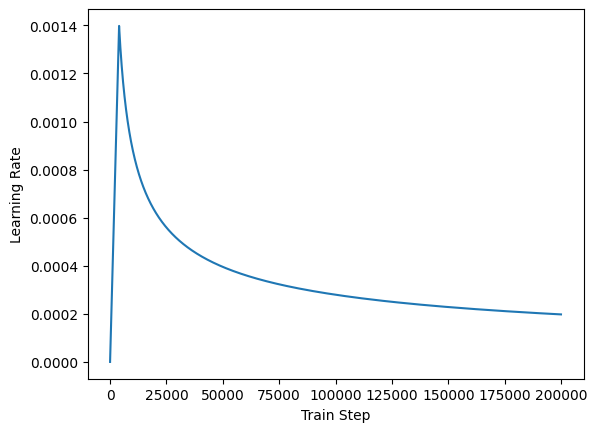

In [77]:
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

* Now let's initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [78]:
learning_rate = CustomScheduleFloat(d_model=128)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Now let's write custom accuracy function and clear any previous model and compile newly created model

In [79]:
# Clear backend
tf.keras.backend.clear_session()

# Accuracy function
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# Creating model
transformer = Transformer(num_layers=NUM_LAYERS, d_model=D_MODEL, num_heads=NUM_HEADS, dff=UNITS,
                          input_vocab_size=VOCAB_SIZE, target_vocab_size=VOCAB_SIZE, 
                          pe_input=VOCAB_SIZE, 
                          pe_target=VOCAB_SIZE,
                          rate=DROPOUT)

# Compiling model
transformer.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

* Let's write a function to create all three masks required by transformer 

In [80]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tar)
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return enc_padding_mask, combined_mask, dec_padding_mask

* Let's define training metrics

In [81]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

* Let's now write training function

In [82]:
# for our corpus
train_step_signature = [
    tf.TensorSpec(shape=(None, 20), dtype=tf.int32),
    tf.TensorSpec(shape=(None, 20), dtype=tf.int32),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    # Creating masks
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    # Forward pass
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, training=True, 
                               enc_padding_mask=enc_padding_mask, 
                               look_ahead_mask=combined_mask,
                               dec_padding_mask=dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    # Backward pass
    gradients = tape.gradient(loss, transformer.trainable_variables)   
    # Updating weights
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    # Updating metrics
    train_loss(loss)
    train_accuracy(tar_real, predictions)

* Now let's write a training loop

In [83]:
for epoch in range(EPOCHS):
    train_loss.reset_state()
    train_accuracy.reset_state()
    for (batch, (inp, tar)) in enumerate(dataset):
        enc_input = inp['inputs']
        target = tar['outputs']
        train_step(enc_input, target)
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    # Save model weights every 50 epochs
    if (epoch + 1) % 50 == 0:
        weights_path = f'weights/transformer_weights_epoch_{epoch+1}.weights.h5'
        transformer.save_weights(weights_path)
        print(f'Saved weights for epoch {epoch+1} at {weights_path}')
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}\n')

Epoch 1 Batch 0 Loss 8.1015 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.1029 Accuracy 0.0000
Epoch 1 Batch 100 Loss 7.9937 Accuracy 0.0002
Epoch 1 Batch 150 Loss 7.8260 Accuracy 0.0006
Epoch 1 Batch 200 Loss 7.6610 Accuracy 0.0009
Epoch 1 Batch 250 Loss 7.4940 Accuracy 0.0012
Epoch 1 Batch 300 Loss 7.3438 Accuracy 0.0018
Epoch 1 Batch 350 Loss 7.2087 Accuracy 0.0027
Epoch 1 Batch 400 Loss 7.0823 Accuracy 0.0043
Epoch 1 Batch 450 Loss 6.9572 Accuracy 0.0062
Epoch 1 Batch 500 Loss 6.8287 Accuracy 0.0085
Epoch 1 Batch 550 Loss 6.7010 Accuracy 0.0114
Epoch 1 Batch 600 Loss 6.5663 Accuracy 0.0150
Epoch 1 Batch 650 Loss 6.4186 Accuracy 0.0199
Epoch 1 Batch 700 Loss 6.2636 Accuracy 0.0257
Epoch 1 Batch 750 Loss 6.1096 Accuracy 0.0323
Epoch 1 Batch 800 Loss 5.9560 Accuracy 0.0404
Epoch 1 Batch 850 Loss 5.7927 Accuracy 0.0500
Epoch 1 Batch 900 Loss 5.6213 Accuracy 0.0602
Epoch 1 Batch 950 Loss 5.4466 Accuracy 0.0705
Epoch 1 Batch 1000 Loss 5.2717 Accuracy 0.0811
Epoch 1 Batch 1050 Loss 5.1007 Accur

2025-12-10 04:51:47.528025: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Batch 50 Loss 5.5194 Accuracy 0.0031
Epoch 2 Batch 100 Loss 5.1337 Accuracy 0.0059
Epoch 2 Batch 150 Loss 4.8417 Accuracy 0.0089
Epoch 2 Batch 200 Loss 4.5814 Accuracy 0.0120
Epoch 2 Batch 250 Loss 4.3220 Accuracy 0.0163
Epoch 2 Batch 300 Loss 4.0907 Accuracy 0.0207
Epoch 2 Batch 350 Loss 3.8735 Accuracy 0.0261
Epoch 2 Batch 400 Loss 3.6720 Accuracy 0.0321
Epoch 2 Batch 450 Loss 3.4728 Accuracy 0.0391
Epoch 2 Batch 500 Loss 3.2799 Accuracy 0.0474
Epoch 2 Batch 550 Loss 3.0880 Accuracy 0.0570
Epoch 2 Batch 600 Loss 2.9071 Accuracy 0.0683
Epoch 2 Batch 650 Loss 2.7342 Accuracy 0.0816
Epoch 2 Batch 700 Loss 2.5802 Accuracy 0.0955
Epoch 2 Batch 750 Loss 2.4523 Accuracy 0.1079
Epoch 2 Batch 800 Loss 2.3399 Accuracy 0.1221
Epoch 2 Batch 850 Loss 2.2358 Accuracy 0.1365
Epoch 2 Batch 900 Loss 2.1373 Accuracy 0.1495
Epoch 2 Batch 950 Loss 2.0450 Accuracy 0.1613
Epoch 2 Batch 1000 Loss 1.9594 Accuracy 0.1722
Epoch 2 Batch 1050 Loss 1.8810 Accuracy 0.1821
Epoch 2 Batch 1100 Loss 1.8081 Ac

2025-12-10 04:52:03.977640: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3 Batch 50 Loss 4.5567 Accuracy 0.0053
Epoch 3 Batch 100 Loss 4.2338 Accuracy 0.0087
Epoch 3 Batch 150 Loss 3.8958 Accuracy 0.0123
Epoch 3 Batch 200 Loss 3.5895 Accuracy 0.0166
Epoch 3 Batch 250 Loss 3.3177 Accuracy 0.0215
Epoch 3 Batch 300 Loss 3.0651 Accuracy 0.0275
Epoch 3 Batch 350 Loss 2.8381 Accuracy 0.0339
Epoch 3 Batch 400 Loss 2.6345 Accuracy 0.0409
Epoch 3 Batch 450 Loss 2.4475 Accuracy 0.0489
Epoch 3 Batch 500 Loss 2.2757 Accuracy 0.0578
Epoch 3 Batch 550 Loss 2.1212 Accuracy 0.0676
Epoch 3 Batch 600 Loss 1.9764 Accuracy 0.0796
Epoch 3 Batch 650 Loss 1.8455 Accuracy 0.0935
Epoch 3 Batch 700 Loss 1.7345 Accuracy 0.1069
Epoch 3 Batch 750 Loss 1.6418 Accuracy 0.1196
Epoch 3 Batch 800 Loss 1.5640 Accuracy 0.1337
Epoch 3 Batch 850 Loss 1.4904 Accuracy 0.1486
Epoch 3 Batch 900 Loss 1.4219 Accuracy 0.1614
Epoch 3 Batch 950 Loss 1.3595 Accuracy 0.1728
Epoch 3 Batch 1000 Loss 1.3023 Accuracy 0.1834
Epoch 3 Batch 1050 Loss 1.2500 Accuracy 0.1930
Epoch 3 Batch 1100 Loss 1.2022 Ac

2025-12-10 04:52:36.885129: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 5 Batch 50 Loss 4.4736 Accuracy 0.0069
Epoch 5 Batch 100 Loss 4.1485 Accuracy 0.0093
Epoch 5 Batch 150 Loss 3.7572 Accuracy 0.0133
Epoch 5 Batch 200 Loss 3.4220 Accuracy 0.0178
Epoch 5 Batch 250 Loss 3.1217 Accuracy 0.0231
Epoch 5 Batch 300 Loss 2.8487 Accuracy 0.0291
Epoch 5 Batch 350 Loss 2.6106 Accuracy 0.0361
Epoch 5 Batch 400 Loss 2.3915 Accuracy 0.0439
Epoch 5 Batch 450 Loss 2.1958 Accuracy 0.0525
Epoch 5 Batch 500 Loss 2.0269 Accuracy 0.0616
Epoch 5 Batch 550 Loss 1.8761 Accuracy 0.0722
Epoch 5 Batch 600 Loss 1.7424 Accuracy 0.0840
Epoch 5 Batch 650 Loss 1.6228 Accuracy 0.0975
Epoch 5 Batch 700 Loss 1.5219 Accuracy 0.1111
Epoch 5 Batch 750 Loss 1.4413 Accuracy 0.1232
Epoch 5 Batch 800 Loss 1.3721 Accuracy 0.1373
Epoch 5 Batch 850 Loss 1.3065 Accuracy 0.1516
Epoch 5 Batch 900 Loss 1.2449 Accuracy 0.1644
Epoch 5 Batch 950 Loss 1.1878 Accuracy 0.1763
Epoch 5 Batch 1000 Loss 1.1359 Accuracy 0.1866
Epoch 5 Batch 1050 Loss 1.0889 Accuracy 0.1963
Epoch 5 Batch 1100 Loss 1.0461 Ac

2025-12-10 04:53:42.686766: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 9 Batch 50 Loss 2.8861 Accuracy 0.0111
Epoch 9 Batch 100 Loss 2.6570 Accuracy 0.0154
Epoch 9 Batch 150 Loss 2.4245 Accuracy 0.0195
Epoch 9 Batch 200 Loss 2.1892 Accuracy 0.0245
Epoch 9 Batch 250 Loss 1.9737 Accuracy 0.0306
Epoch 9 Batch 300 Loss 1.7848 Accuracy 0.0371
Epoch 9 Batch 350 Loss 1.6166 Accuracy 0.0446
Epoch 9 Batch 400 Loss 1.4745 Accuracy 0.0523
Epoch 9 Batch 450 Loss 1.3482 Accuracy 0.0609
Epoch 9 Batch 500 Loss 1.2392 Accuracy 0.0701
Epoch 9 Batch 550 Loss 1.1434 Accuracy 0.0802
Epoch 9 Batch 600 Loss 1.0587 Accuracy 0.0920
Epoch 9 Batch 650 Loss 0.9842 Accuracy 0.1056
Epoch 9 Batch 700 Loss 0.9216 Accuracy 0.1192
Epoch 9 Batch 750 Loss 0.8693 Accuracy 0.1319
Epoch 9 Batch 800 Loss 0.8246 Accuracy 0.1462
Epoch 9 Batch 850 Loss 0.7845 Accuracy 0.1606
Epoch 9 Batch 900 Loss 0.7468 Accuracy 0.1734
Epoch 9 Batch 950 Loss 0.7126 Accuracy 0.1849
Epoch 9 Batch 1000 Loss 0.6816 Accuracy 0.1955
Epoch 9 Batch 1050 Loss 0.6532 Accuracy 0.2051
Epoch 9 Batch 1100 Loss 0.6270 Ac

2025-12-10 04:55:54.313234: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 17 Batch 50 Loss 1.7856 Accuracy 0.0170
Epoch 17 Batch 100 Loss 1.6139 Accuracy 0.0215
Epoch 17 Batch 150 Loss 1.4792 Accuracy 0.0260
Epoch 17 Batch 200 Loss 1.3464 Accuracy 0.0309
Epoch 17 Batch 250 Loss 1.2211 Accuracy 0.0368
Epoch 17 Batch 300 Loss 1.1050 Accuracy 0.0432
Epoch 17 Batch 350 Loss 1.0036 Accuracy 0.0504
Epoch 17 Batch 400 Loss 0.9105 Accuracy 0.0581
Epoch 17 Batch 450 Loss 0.8298 Accuracy 0.0664
Epoch 17 Batch 500 Loss 0.7604 Accuracy 0.0757
Epoch 17 Batch 550 Loss 0.7018 Accuracy 0.0855
Epoch 17 Batch 600 Loss 0.6492 Accuracy 0.0971
Epoch 17 Batch 650 Loss 0.6033 Accuracy 0.1103
Epoch 17 Batch 700 Loss 0.5646 Accuracy 0.1236
Epoch 17 Batch 750 Loss 0.5320 Accuracy 0.1364
Epoch 17 Batch 800 Loss 0.5048 Accuracy 0.1506
Epoch 17 Batch 850 Loss 0.4791 Accuracy 0.1652
Epoch 17 Batch 900 Loss 0.4557 Accuracy 0.1782
Epoch 17 Batch 950 Loss 0.4344 Accuracy 0.1895
Epoch 17 Batch 1000 Loss 0.4148 Accuracy 0.2002
Epoch 17 Batch 1050 Loss 0.3970 Accuracy 0.2097
Epoch 17 Bat

2025-12-10 05:00:17.574598: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 33 Batch 50 Loss 1.2699 Accuracy 0.0204
Epoch 33 Batch 100 Loss 1.1587 Accuracy 0.0248
Epoch 33 Batch 150 Loss 1.0688 Accuracy 0.0295
Epoch 33 Batch 200 Loss 0.9830 Accuracy 0.0342
Epoch 33 Batch 250 Loss 0.8981 Accuracy 0.0396
Epoch 33 Batch 300 Loss 0.8199 Accuracy 0.0461
Epoch 33 Batch 350 Loss 0.7453 Accuracy 0.0531
Epoch 33 Batch 400 Loss 0.6787 Accuracy 0.0605
Epoch 33 Batch 450 Loss 0.6208 Accuracy 0.0689
Epoch 33 Batch 500 Loss 0.5692 Accuracy 0.0777
Epoch 33 Batch 550 Loss 0.5241 Accuracy 0.0880
Epoch 33 Batch 600 Loss 0.4841 Accuracy 0.0993
Epoch 33 Batch 650 Loss 0.4494 Accuracy 0.1126
Epoch 33 Batch 700 Loss 0.4204 Accuracy 0.1260
Epoch 33 Batch 750 Loss 0.3964 Accuracy 0.1383
Epoch 33 Batch 800 Loss 0.3752 Accuracy 0.1525
Epoch 33 Batch 850 Loss 0.3560 Accuracy 0.1668
Epoch 33 Batch 900 Loss 0.3382 Accuracy 0.1799
Epoch 33 Batch 950 Loss 0.3221 Accuracy 0.1915
Epoch 33 Batch 1000 Loss 0.3073 Accuracy 0.2019
Epoch 33 Batch 1050 Loss 0.2940 Accuracy 0.2112
Epoch 33 Bat

2025-12-10 05:09:02.025412: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 65 Batch 50 Loss 1.0034 Accuracy 0.0209
Epoch 65 Batch 100 Loss 0.9425 Accuracy 0.0257
Epoch 65 Batch 150 Loss 0.8787 Accuracy 0.0308
Epoch 65 Batch 200 Loss 0.8165 Accuracy 0.0358
Epoch 65 Batch 250 Loss 0.7485 Accuracy 0.0414
Epoch 65 Batch 300 Loss 0.6792 Accuracy 0.0478
Epoch 65 Batch 350 Loss 0.6191 Accuracy 0.0544
Epoch 65 Batch 400 Loss 0.5642 Accuracy 0.0621
Epoch 65 Batch 450 Loss 0.5140 Accuracy 0.0705
Epoch 65 Batch 500 Loss 0.4699 Accuracy 0.0797
Epoch 65 Batch 550 Loss 0.4321 Accuracy 0.0896
Epoch 65 Batch 600 Loss 0.3994 Accuracy 0.1008
Epoch 65 Batch 650 Loss 0.3709 Accuracy 0.1136
Epoch 65 Batch 700 Loss 0.3465 Accuracy 0.1271
Epoch 65 Batch 750 Loss 0.3263 Accuracy 0.1397
Epoch 65 Batch 800 Loss 0.3085 Accuracy 0.1545
Epoch 65 Batch 850 Loss 0.2924 Accuracy 0.1690
Epoch 65 Batch 900 Loss 0.2776 Accuracy 0.1815
Epoch 65 Batch 950 Loss 0.2640 Accuracy 0.1930
Epoch 65 Batch 1000 Loss 0.2517 Accuracy 0.2034
Epoch 65 Batch 1050 Loss 0.2406 Accuracy 0.2127
Epoch 65 Bat

* As you can see from above that training is completed
* Now let's write a code to load saved weights

In [84]:
# Build the model by calling it once with sample data
sample_input = tf.zeros((1, 20), dtype=tf.int32)
sample_target = tf.zeros((1, 19), dtype=tf.int32)

enc_padding_mask, combined_mask, dec_padding_mask = create_masks(sample_input, sample_target)

# This actually builds the model
_ = transformer(
    sample_input, 
    sample_target, 
    training=False,
    enc_padding_mask=enc_padding_mask,
    look_ahead_mask=combined_mask,
    dec_padding_mask=dec_padding_mask
)

print("Model built successfully!")

transformer.load_weights(f'./weights/transformer_weights_epoch_{EPOCHS}.weights.h5')

Model built successfully!


* Now let's write a function for making predictions

In [85]:
def evaluate(sentence):
    # Encoding input
    encoded = tokenizer.texts_to_sequences([sentence])[0]
    encoder_input = tf.expand_dims([START_TOKEN] + encoded + [END_TOKEN], axis=0)
    # Starting decoder with start token
    decoder_input = tf.expand_dims([START_TOKEN], 0)
    # Generating tokens one by one
    for i in range(MAX_LENGTH):
        # Creating masks
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, decoder_input
        )
        # Getting predictions
        predictions, attention_weights = transformer(
            encoder_input, 
            decoder_input,
            training=False,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask
        )
        # Getting last positions predictions
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # Stopping if end token
        if tf.equal(predicted_id, END_TOKEN):
            break
        # Adding predicted token to decoder input
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)
    return tf.squeeze(decoder_input, axis=0), attention_weights

def predict(sentence):
    # Geting prediction
    prediction, attention_weights = evaluate(sentence)
    # Filtering out special tokens
    sequence = [i for i in prediction.numpy().tolist() 
                if i != START_TOKEN and i != END_TOKEN and i > 0]
    # Converting to text
    predicted_sentence = tokenizer.sequences_to_texts([sequence])[0]
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    return predicted_sentence, attention_weights

* Let's now test the prediction function

In [86]:
output, attention = predict("There is no purer love than the love of a student for their professor")

Input: There is no purer love than the love of a student for their professor
Output: is no love than the love of a dateless lively heat nor my five no longer than thy love


* As you can see from above our prediction function is working as expected
* Now let's write a function to generate poem

In [87]:
def generate_poem(seed_text, num_lines=4, words_per_line=8):
    """Generate poem given text"""
    poem_lines = []
    current_text = seed_text
    for line_num in range(num_lines):
        # Generating next sequence
        predicted, _ = evaluate(current_text)
        # Converting to words
        sequence = [i for i in predicted.numpy().tolist() 
                    if i != START_TOKEN and i != END_TOKEN and i > 0]
        predicted_words = tokenizer.sequences_to_texts([sequence])[0]
        words = predicted_words.split()
        # Taking words for this line
        line_words = words[:words_per_line]
        line = ' '.join(line_words)
        poem_lines.append(line)
        # Using end of this line as seed for next line
        if len(words) >= 3:
            current_text = ' '.join(words[-3:])  # Last 3 words as new seed
        else:
            current_text = predicted_words
    poem = '\n'.join(poem_lines)
    return poem

* Let's test this function

In [88]:
print(generate_poem("shall i compare thee", num_lines=4, words_per_line=8))

i compare thee
thee
thee how to have years be new
be new made when a new pride
